In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, BatchNormalization, ZeroPadding2D, Input, MaxPool2D, Concatenate, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.layers import ReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras import layers, models

import torch
import pandas as pd
import os
import random
import matplotlib.pyplot as plt

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'


2024-04-23 23:41:19.591294: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-23 23:41:19.658495: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
torch.cuda.is_available()

Num GPUs Available:  8


True

In [3]:
TRAINING_DIR = '/usr/cs/grad/doc/2027/spatel2/MachineLearning/ML_Project/ML_Project/birds-525/train/'
VALIDATION_DIR = '/usr/cs/grad/doc/2027/spatel2/MachineLearning/ML_Project/ML_Project/birds-525/valid/'
TESTING_DIR = '/usr/cs/grad/doc/2027/spatel2/MachineLearning/ML_Project/ML_Project/birds-525/test/'
BATCH_SIZE = 16
INPUT_SHAPE = (224, 224)
SEED = 777
EPOCHS = 2
GROW_RATE = 16
BASE_FILTERS = 12
NUM_CLASSES = 525
IMAGES_SHAPE = (224, 224, 3)

In [4]:
tf.random.set_seed(SEED)

Found 84635 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.
Found 84635 images belonging to 525 classes.
Batch index: 2576


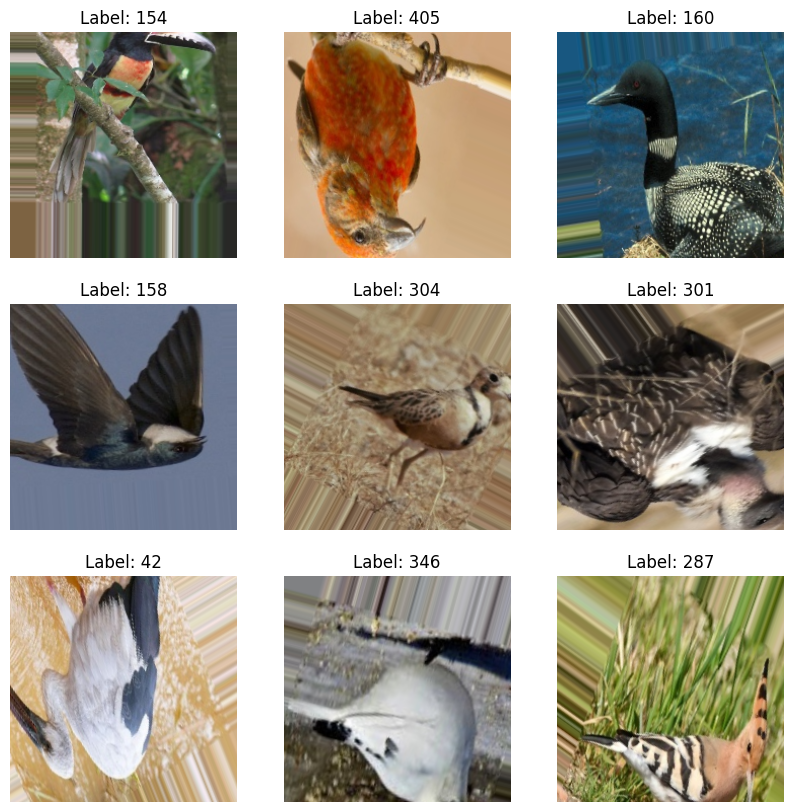

In [5]:
training_gen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    vertical_flip=True,
    rotation_range=40
)
training_set = training_gen.flow_from_directory(
    TRAINING_DIR,
    batch_size=BATCH_SIZE,
    target_size=INPUT_SHAPE,
    class_mode='categorical'
)
validation_gen = ImageDataGenerator(rescale=1./255)
validation_set = validation_gen.flow_from_directory(
    VALIDATION_DIR,
    batch_size=BATCH_SIZE,
    target_size=INPUT_SHAPE,
    class_mode='categorical'
)

testing_gen = ImageDataGenerator(rescale=1./255)
testing_set = testing_gen.flow_from_directory(
    TESTING_DIR,
    batch_size=BATCH_SIZE,
    target_size=INPUT_SHAPE,
    class_mode='categorical'
)
# Generating images
generated_images = next(training_gen.flow_from_directory(
    TRAINING_DIR,
    batch_size=9,
    target_size=INPUT_SHAPE,
    class_mode=None,
    shuffle=False
))


def decode_one_hot(labels):
    return [label.argmax() for label in labels]


# Choose a random batch index from the dataset
batch_index = random.randint(0, len(training_set) - 1)
print("Batch index:", batch_index)

# Retrieve the batch of images and labels
random_images, random_labels = training_set[batch_index]

# Decode the one-hot encoded labels
random_labels = decode_one_hot(random_labels)

# Limit the number of images to display to 9
num_images_to_display = min(len(random_images), 9)

# Display the random images with their corresponding class labels
plt.figure(figsize=(10, 10))
for i in range(num_images_to_display):
    plt.subplot(3, 3, i + 1)
    plt.imshow(random_images[i])
    plt.title(f"Label: {random_labels[i]}")
    plt.axis("off")
plt.show()

In [6]:
def resnet_block(input_layer, num_filters, kernel_size=3, strides=1, activation='relu'):
    x = layers.Conv2D(num_filters, kernel_size=kernel_size,
                      strides=strides, padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(activation)(x)
    x = layers.Conv2D(num_filters, kernel_size=kernel_size,
                      strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Add shortcut connection
    if strides != 1:
        input_layer = layers.Conv2D(
            num_filters, kernel_size=1, strides=strides, padding='same')(input_layer)
    x = layers.add([x, input_layer])
    x = layers.Activation(activation)(x)
    return x


def build_resnet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Initial Conv Layer
    x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    # ResNet blocks
    x = resnet_block(x, 64)
    x = resnet_block(x, 64)
    x = resnet_block(x, 128, strides=2)
    x = resnet_block(x, 128)
    x = resnet_block(x, 256, strides=2)
    x = resnet_block(x, 256)

    # Classification head
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model


# Parameters
input_shape = (224, 224, 3)  
num_classes = 525  

# Build the model
model = build_resnet(input_shape, num_classes)
# model.summary()

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])


2024-04-23 23:41:39.433105: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-04-23 23:41:39.433417: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7753 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:4f:00.0, compute capability: 8.9
2024-04-23 23:41:39.433993: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-04-23 23:41:39.434302: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 29569 MB memory:  -> device: 1, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:52:00.0, compute capability: 8.9
2024-04-23 23:41:39.434716: W

In [7]:
# Train the model
history = model.fit(
    training_set,
    # steps_per_epoch = len(training_set),
    epochs=10,
    validation_data=validation_set,
    # validation_steps=int(0.25*len(validation_set))
)

# Save the model
model.save('resnet_model.h5')


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1713915710.527864 1130793 service.cc:145] XLA service 0x7f97440020e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1713915710.527912 1130793 service.cc:153]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
I0000 00:00:1713915710.527922 1130793 service.cc:153]   StreamExecutor device (1): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
I0000 00:00:1713915710.527925 1130793 service.cc:153]   StreamExecutor device (2): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
I0000 00:00:1713915710.527930 1130793 service

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

NameError: name 'history' is not defined